# モジュール

In [1]:
import os
import sys
import warnings

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
sys.path.append(os.getcwd())
sys.path.append("..")
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# TF/Keras
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.layers import Input, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.manifold import TSNE



# Data



In [2]:

def make_timeseries_dataset(data, target, timesteps):
    #タイムステップ分ずらす
    N = len(target[timesteps:])
    X = np.zeros((N, timesteps, 1), np.float32)
    Y = np.zeros((N, 1), np.float32)
    for i in range(N):
        X[i] = data[i:i+timesteps][:,np.newaxis]
        Y[i] = target[i+timesteps]
    return X, Y

def make_dataset_for_stateful(data_list, target_list, timesteps):
    N = len(data_list)
    X = []
    Y = []
    for i in range(N):
        x, y = make_timeseries_dataset(data_list[i], target_list[i], timesteps)
        X.append(x)
        Y.append(y)
    X = np.concatenate(X, axis=(1)).reshape(-1, timesteps, 1)
    Y = np.concatenate(Y, axis=(1)).reshape(-1, 1)

    return X, Y

# Model

In [3]:
def build_encoder(input_shape, h_dim, z_dim, name="encoder"):
    #入力層
    inputs = keras.layers.Input(shape=input_shape)
    #隠れ層，h_dim個のユニット，ReLU関数
    #入力データを非線形変換
    x = keras.layers.Dense(h_dim, activation="relu")(inputs)
    #別の隠れ層，ネットワークの表現能力を向上
    x = keras.layers.Dense(h_dim, activation="relu")(x)
    z_mean = keras.layers.Dense(z_dim, name="z_mean")(x)
    z_log_var = keras.layers.Dense(z_dim, name="z_log_var")(x)
    #潜在空間の平均と対数分散を出力
    outputs = [z_mean, z_log_var]
    
    
    return keras.Model(inputs=inputs, outputs=outputs, name=name)

#事前モデル分布
def build_prior(input_shape, h_dim, z_dim, name="prior"):
    inputs = keras.layers.Input(shape=input_shape)
    x = keras.layers.Dense(h_dim, activation="relu")(inputs) 
    prior_mean = keras.layers.Dense(z_dim, name="prior_mean")(x)
    prior_log_var = keras.layers.Dense(z_dim, name="prior_log_var")(x)
    #潜在空間の事前分布の平均を出力
    outputs = [prior_mean, prior_log_var]
    
    return keras.Model(inputs=inputs, outputs=outputs, name=name)

def build_decoder(input_shape, h_dim, x_dim, name="decoder"):
    inputs = keras.layers.Input(shape=input_shape)
    x = keras.layers.Dense(h_dim, activation="relu")(inputs)
    x = keras.layers.Dense(h_dim, activation="relu")(x)
    x = keras.layers.Dense(x_dim)(x)
    outputs = x
    
    return keras.Model(inputs=inputs, outputs=outputs, name=name)

class Sampling(keras.layers.Layer):
    def __init__(self, name="sampling"):
        super().__init__(name=name)
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        #潜在変数 = 期待値(u) + 標準偏差(σ) * 乱数
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
class VRNNCell(keras.layers.Layer):
    def __init__(self, h_dim, z_dim):
        super().__init__()
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.state_size = h_dim

    def build(self, input_shape):
        batch_size, x_dim = input_shape

        #phi 特徴抽出
        self.phi_x_layer = keras.Sequential([
            keras.layers.Input((x_dim)),
            keras.layers.Dense(self.h_dim, activation="relu"),
            keras.layers.Dense(self.h_dim, activation="relu")
        ])
        self.phi_z_layer = keras.layers.Dense(self.h_dim, activation="relu")
        self.encoder = build_encoder(input_shape=(self.h_dim+self.h_dim), h_dim=self.h_dim, z_dim=self.z_dim)
        self.prior_layer = build_prior(input_shape=(self.h_dim), h_dim=self.h_dim, z_dim=self.z_dim)
        self.decoder = build_decoder(input_shape=(self.h_dim+self.h_dim), h_dim=self.h_dim, x_dim=x_dim)

        self.rnn_cell = keras.layers.GRUCell(self.h_dim)

        self.sampling_layer = Sampling()

    def call(self, inputs, states):
        h = states[0]   # B x h_dim

        phi_x = self.phi_x_layer(inputs)    # B x h_dim
        x = keras.layers.Concatenate(axis=(1))([phi_x, h])  # B x h_dim+h_dim

        # encoder
        z_mean, z_log_var = self.encoder(x)     # B x z_dim, B x z_dim

        # prior
        prior_mean, prior_log_var = self.prior_layer(h)     # B x z_dim, B x z_dim

        # reparametrization trick
        z = self.sampling_layer([z_mean, z_log_var])    # B x z_dim

        phi_z = self.phi_z_layer(z)     # B x z_dim
        x = keras.layers.Concatenate(axis=(1))([phi_z, h])  # B x h_dim+h_dim

        #decoder
        y = self.decoder(x)   # B x z_dim

        #recurrence
        phi = keras.layers.Concatenate(axis=(1))([phi_x, phi_z])
        _, new_h = self.rnn_cell(phi, [h])    # B x h_dim

        outputs = [y, z_mean, z_log_var, prior_mean, prior_log_var, z, phi_z, h]
        new_states = [new_h]    # 1 x B x h_dim
        return outputs, new_states

In [5]:
class VRNN(keras.Model):
    def __init__(self, input_shape, h_dim=100, z_dim=32, return_sequences=False, name="vrnn", *args, **kwargs):
        super().__init__(name=name, *args, **kwargs)
        self.cell = VRNNCell(h_dim=h_dim, z_dim=z_dim)
        self.axis = (1, 2) if return_sequences else (1)

        # build model
        inputs = keras.layers.Input(input_shape)
        x = keras.layers.RNN(self.cell, return_sequences=return_sequences)(inputs)
        outputs = x
        self.rnn = keras.Model(inputs=inputs, outputs=outputs)

    def call(self, inputs, training=False):
        return self.rnn(inputs)
    
    def compile(self, optimizer, loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.optimizer = optimizer
        self.loss = loss

        # Tracker
        self.total_cost_tracker = keras.metrics.Mean(name="total_cost")
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.kl_tracker = keras.metrics.Mean(name="kl_divergence")

    @property
    def metrics(self):
        return [
            self.total_cost_tracker,
            self.loss_tracker,
            self.kl_tracker
        ]

    def train_step(self, data):
        x, y_true = data
        with tf.GradientTape() as tape:
            outputs = self.rnn(x)
            y_pred, z_mean, z_log_var, prior_mean, prior_log_var, z, phi_z, h = outputs

            # loss
            loss = tf.reduce_mean(self.loss(y_true, y_pred))

            # KL-divergence
            term1 = prior_log_var - z_log_var
            term2 = (tf.exp(z_log_var) + tf.square(z_mean - prior_mean)) / (tf.exp(prior_log_var) + 1e-12)
            term3 = -1
            kl = tf.reduce_mean(tf.reduce_sum(0.5 * (term1 + term2 + term3), axis=self.axis))

            total_cost = loss + kl

        grads = tape.gradient(total_cost, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update
        self.total_cost_tracker.update_state(total_cost)
        self.loss_tracker.update_state(loss)
        self.kl_tracker.update_state(kl)
        
        return {m.name: m.result() for m in self.metrics}

# Delay Model

In [88]:
class VRNNCell(keras.layers.Layer):
    def __init__(self, h_dim, z_dim, delay_steps=5):
        super().__init__()
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.delay_steps = delay_steps  # delay_steps を追加
        self.state_size = h_dim

    def build(self, input_shape):
        batch_size, x_dim = input_shape

        # phi 特徴抽出
        self.phi_x_layer = keras.Sequential([
            keras.layers.Input((x_dim)),
            keras.layers.Dense(self.h_dim, activation="relu"),
            keras.layers.Dense(self.h_dim, activation="relu")
        ])
        self.phi_z_layer = keras.layers.Dense(self.h_dim, activation="relu")
        self.encoder = build_encoder(input_shape=(self.h_dim+self.h_dim), h_dim=self.h_dim, z_dim=self.z_dim)
        self.prior_layer = build_prior(input_shape=(self.h_dim), h_dim=self.h_dim, z_dim=self.z_dim)
        self.decoder = build_decoder(input_shape=(self.h_dim+self.h_dim), h_dim=self.h_dim, x_dim=x_dim)

        self.rnn_cell = keras.layers.GRUCell(self.h_dim)

        self.sampling_layer = Sampling()

    def call(self, inputs, states):
        h = states[0]   # B x h_dim

        # delay_steps に基づいて入力を遅延
        if self.delay_steps > 0:
            inputs = tf.roll(inputs, shift=self.delay_steps, axis=1)

        phi_x = self.phi_x_layer(inputs)    # B x h_dim
        x = keras.layers.Concatenate(axis=1)([phi_x, h])  # B x h_dim+h_dim

        # encoder
        z_mean, z_log_var = self.encoder(x)     # B x z_dim, B x z_dim

        # prior
        prior_mean, prior_log_var = self.prior_layer(h)     # B x z_dim, B x z_dim

        # reparametrization trick
        z = self.sampling_layer([z_mean, z_log_var])    # B x z_dim

        phi_z = self.phi_z_layer(z)     # B x z_dim
        x = keras.layers.Concatenate(axis=1)([phi_z, h])  # B x h_dim+h_dim

        #decoder
        y = self.decoder(x)   # B x z_dim

        #recurrence
        phi = keras.layers.Concatenate(axis=1)([phi_x, phi_z])
        _, new_h = self.rnn_cell(phi, [h])    # B x h_dim

        outputs = [y, z_mean, z_log_var, prior_mean, prior_log_var, z, phi_z, h]
        new_states = [new_h]    # 1 x B x h_dim
        return outputs, new_states


In [90]:
class VRNN(keras.Model):
    def __init__(self, input_shape, h_dim=100, z_dim=32, delay_steps = 5,return_sequences=False, name="vrnn", *args, **kwargs):
        super().__init__(name=name, *args, **kwargs)
        self.cell = VRNNCell(h_dim=h_dim, z_dim=z_dim)
        self.axis = (1, 2) if return_sequences else (1)

        # build model
        inputs = keras.layers.Input(input_shape)
        x = keras.layers.RNN(self.cell, return_sequences=return_sequences)(inputs)
        outputs = x
        self.rnn = keras.Model(inputs=inputs, outputs=outputs)

    def call(self, inputs, training=False):
        return self.rnn(inputs)
    
    def compile(self, optimizer, loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.optimizer = optimizer
        self.loss = loss

        # Tracker
        self.total_cost_tracker = keras.metrics.Mean(name="total_cost")
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.kl_tracker = keras.metrics.Mean(name="kl_divergence")

    @property
    def metrics(self):
        return [
            self.total_cost_tracker,
            self.loss_tracker,
            self.kl_tracker
        ]

    def train_step(self, data):
        x, y_true = data
        with tf.GradientTape() as tape:
            outputs = self.rnn(x)
            y_pred, z_mean, z_log_var, prior_mean, prior_log_var, z, phi_z, h = outputs

            # loss
            loss = tf.reduce_mean(self.loss(y_true, y_pred))

            # KL-divergence
            term1 = prior_log_var - z_log_var
            term2 = (tf.exp(z_log_var) + tf.square(z_mean - prior_mean)) / (tf.exp(prior_log_var) + 1e-12)
            term3 = -1
            kl = tf.reduce_mean(tf.reduce_sum(0.5 * (term1 + term2 + term3), axis=self.axis))

            total_cost = loss + kl

        grads = tape.gradient(total_cost, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update
        self.total_cost_tracker.update_state(total_cost)
        self.loss_tracker.update_state(loss)
        self.kl_tracker.update_state(kl)
        
        return {m.name: m.result() for m in self.metrics}

# サンプル

#  データの取得

In [6]:
import numpy as np
data_G = np.loadtxt('G_DOSE_10-5.csv', delimiter=',')
data_Q = np.loadtxt('Q_DOSE_10-5.csv', delimiter=',')
data_Qex =np.loadtxt('data_10-8_-7_-6,-6_-7_-8_Q_100_2450.csv', delimiter=',')

In [7]:
# T x N -> N x T
x = data_Q.transpose((1, 0))
x_2450 = data_Qex
y = data_G[:700, :].transpose((1, 0))

In [8]:
x_2450.shape

(27, 2450)

In [9]:
#データ前処理
x_init = x - x[:, 0].reshape((8, 1))
x_init_max = np.max(x_init)
x_init_min = np.min(x_init)
x_norm = x_init/(x_init_max - x_init_min)

y_init = y - y[:, 0].reshape((8, 1))
y_init_max = np.max(y_init)
y_init_min = np.min(y_init)
y_norm = y_init/(y_init_max - y_init_min)

x_2450_init = x_2450 - x_2450[:, 0].reshape((27, 1))
x_2450_init_max = np.max(x_init)
x_2450_init_min = np.min(x_init)
x_2450_norm = x_2450_init/(x_2450_init_max - x_2450_init_min)



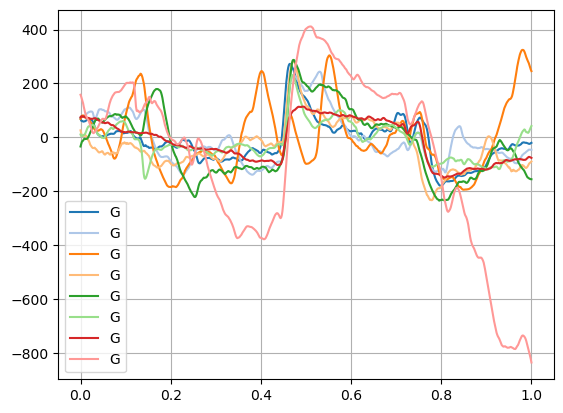

In [10]:
cmap = plt.get_cmap("tab20")

t = np.linspace(0, 1, 700)
# Check
plt.figure()
for i, (x_, y_) in enumerate(zip(x, y)):
    plt.plot(t, x_, linestyle="-", color=cmap(i),label = "G")
    #plt.plot(t, y_, linestyle="--", color=cmap(i), label = "Q")
plt.legend()
plt.grid()
plt.show()

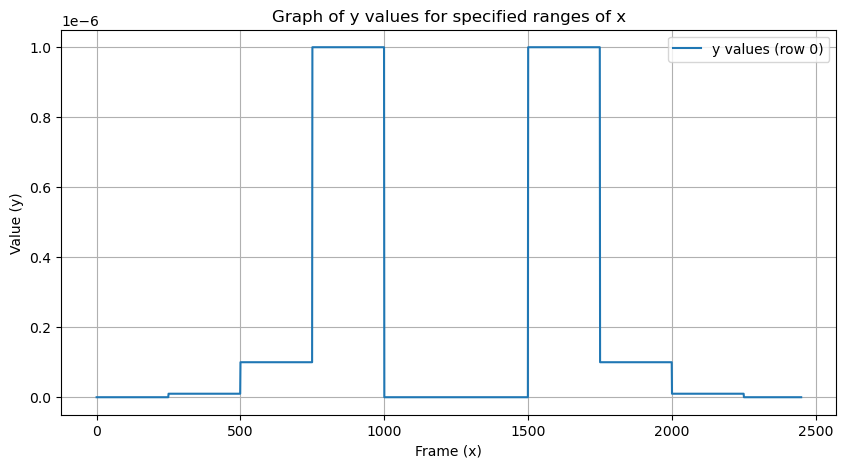

In [11]:

# Number of frames and array dimensions
num_rows = 27
total_frames = 2450

# Initialize y array with zeros
x_si = np.zeros((num_rows, total_frames))

# Apply conditions to each row in the y array
for row in x_si:
    row[250:500] = 1e-8
    row[500:750] = 1e-7
    row[750:1000] = 1e-6
    row[1500:1750] = 1e-6
    row[1750:2000] = 1e-7
    row[2000:2250] = 1e-8

# Plotting the graph for a sample row
plt.figure(figsize=(10, 5))
plt.plot(range(total_frames), x_si[0], label='y values (row 0)')
plt.xlabel('Frame (x)')
plt.ylabel('Value (y)')
plt.title('Graph of y values for specified ranges of x')
plt.legend()
plt.grid(True)
plt.show()

# If you want to save the array to a file, you can use np.save
# np.save('y_array.npy', y)


findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.


findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: 

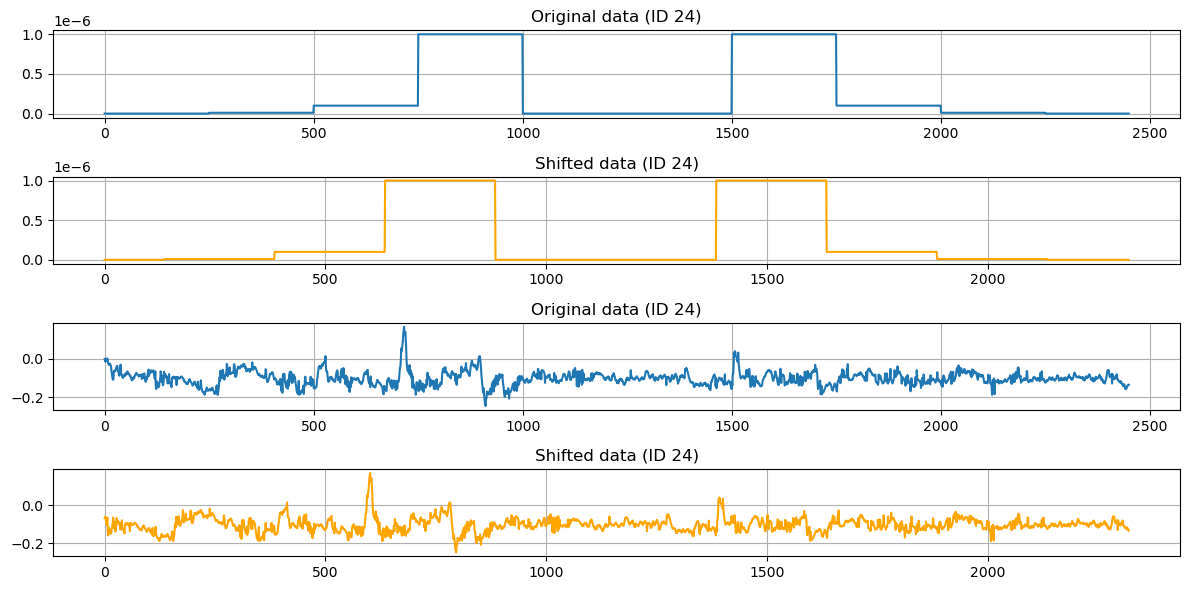

In [57]:
num_individuals = 27
total_frames = 2450
frames_to_keep = 2320

# 各個体のシフト量を定義
shifts = np.arange(0, num_individuals * 5, 5)  # [0, 5, 10, ..., 130]

# シフトを適用した後のデータを格納する配列（短縮されたデータを保持）
x_si_shifted = np.zeros((num_individuals, frames_to_keep))
x_2450_norm_shifted = np.zeros((num_individuals, frames_to_keep))


# 各個体に対してフレームを切り取り、シフトを適用
for i in range(num_individuals):
    shift = shifts[i]

    # truncated_x_si = x_si[i, :frames_to_keep]  # 最初のframes_to_keep(2380)フレームを使用
    # truncated_x_2450 = x_2450_norm[i, :frames_to_keep]

    # # シフトを適用して、前方と後方にゼロを入れる
    # x_si_shifted[i, shift:shift + frames_to_keep] = truncated_x_si
    # x_2450_norm_shifted[i, shift:shift + frames_to_keep] = truncated_x_2450
    
    # データを指定したフレーム数までに切り取り
    truncated_x_si = x_si[i, shift:frames_to_keep+shift]
    truncated_x_2450 = x_2450_norm[i, shift:frames_to_keep+shift]

    # シフトを適用
    x_si_shifted[i,:] = truncated_x_si  # 右にずらす
    x_2450_norm_shifted[i,:] = truncated_x_2450


# 例として、1つの個体の元データとシフト後のデータを比較して表示
plt.figure(figsize=(12, 6))

# 1番目の個体の元データとシフト後データをプロット
individual_to_plot = 23
plt.subplot(4, 1, 1)
plt.plot(x_si[individual_to_plot], label="Original data")
plt.title(f"Original data (ID {individual_to_plot + 1})")
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(x_si_shifted[individual_to_plot], label='Shifted data', color='orange')
plt.title(f'Shifted data (ID {individual_to_plot + 1})')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(x_2450_norm[individual_to_plot], label='Original data')
plt.title(f'Original data (ID {individual_to_plot + 1})')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(x_2450_norm_shifted[individual_to_plot], label='Shifted data', color='orange')
plt.title(f'Shifted data (ID {individual_to_plot + 1})')
plt.grid(True)

plt.tight_layout()
#plt.savefig(f"./result/vrnn_predict/shited_data.png")
plt.show()



array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130])

(27, 2400)

In [58]:
timesteps = 10

#700frame
# x_norm1 = x_norm[:5, :]
# y_norm1 = x_norm[:5, :]

# train_x, train_y = make_dataset_for_stateful(x_norm1, y_norm1, timesteps)

#2450frame
x_ex = data_Qex[:20, :]
y_ex = data_Qex[:20, :]

# train_x, train_y = make_dataset_for_stateful(x_ex, y_ex, timesteps)

x_ex_split = x_ex[:, :100]
y_ex_split = y_ex[:, :100]


x_2450_norm1 = x_2450_norm[:20, :]
y_2450_norm1 = x_2450_norm[:20, :]
# train_x, train_y = make_dataset_for_stateful(x_2450[:20, :], x_2450[:20, :], timesteps)

train_x, train_y = make_dataset_for_stateful(x_si_shifted[:20, :], x_2450_norm_shifted[:20, :], timesteps)



# モデルの取得

In [91]:
#ハイパラ
x_dim = 1
h_dim = 100
z_dim = 32
learning_rate = 0.0001
epochs=30

model = VRNN(input_shape=(timesteps, x_dim), h_dim=h_dim, z_dim=z_dim)

# 学習


In [92]:
loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss=loss)

#%load_ext tensorboard
# TensorBoardコールバックの作成
#tb_cb1 = tf.keras.callbacks.TensorBoard(
#histogram_freq=1,
#write_images=True
#)


In [93]:
hist = model.fit(
    train_x, train_y,
    batch_size=20,
    epochs=epochs,
    #callbacks=[tb_cb1]
)

Epoch 1/30


2310/2310 [==============================] - 92s 37ms/step - total_cost: 0.0499 - loss: 0.0298 - kl_divergence: 0.0201
Epoch 2/30
2310/2310 [==============================] - 88s 38ms/step - total_cost: 0.0273 - loss: 0.0273 - kl_divergence: 1.7176e-06
Epoch 3/30
2310/2310 [==============================] - 88s 38ms/step - total_cost: 0.0270 - loss: 0.0270 - kl_divergence: 6.0464e-07
Epoch 4/30
2310/2310 [==============================] - 87s 38ms/step - total_cost: 0.0269 - loss: 0.0269 - kl_divergence: 1.1763e-07
Epoch 5/30
2310/2310 [==============================] - 87s 38ms/step - total_cost: 0.0269 - loss: 0.0269 - kl_divergence: 1.7927e-07
Epoch 6/30
2310/2310 [==============================] - 87s 37ms/step - total_cost: 0.0268 - loss: 0.0268 - kl_divergence: 5.3060e-08
Epoch 7/30
2310/2310 [==============================] - 86s 37ms/step - total_cost: 0.0268 - loss: 0.0268 - kl_divergence: -4.0692e-08
Epoch 8/30
2310/2310 [==============================] - 88s 38ms/step - tota

In [ ]:
#tensorboard --logdir=. --port=6007

In [ ]:
#from IPython.display import display, HTML
#display(HTML('<a href="http://localhost:6006/" target="_blank">Open TensorBoard</a>'))

In [ ]:
#rm -rf ./logs/

# 推論

In [96]:
id = 24
pre_id = id - 1

# x_norm_ = x_norm[pre_id].reshape(1, -1)
# y_norm_ = y_norm[pre_id].reshape(1, -1)

# test_x, _ = make_dataset_for_stateful(x_norm_, y_norm_, timesteps)

x_2450_ = x_2450[pre_id].reshape(1, -1)
x_si_shifted[pre_id, :]


test_x, _ = make_dataset_for_stateful(x_si_shifted[pre_id, :].reshape(1, -1), x_si_shifted[pre_id, :].reshape(1, -1), timesteps)

outputs = model(test_x)

pred_y = outputs[0]




findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: 

findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: 

<function matplotlib.pyplot.show(close=None, block=None)>

findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: 

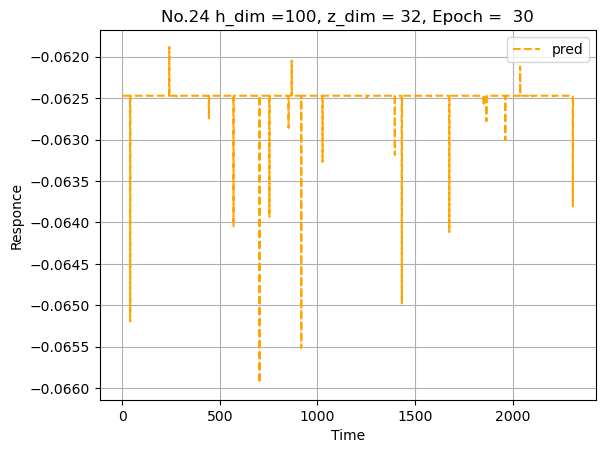

In [97]:
plt.figure()
plt.title("No.{} h_dim ={:<3d}, z_dim = {:>2d}, Epoch = {:>3d}".format(id, h_dim, z_dim, epochs))
# plt.plot(np.squeeze(data_Qex[pre_id, :]), linestyle="-", color="cornflowerblue", label="x")
#plt.plot(np.squeeze(x_2450_norm_shifted[pre_id]), linestyle="-", color="cornflowerblue", label="x")

#plt.plot(np.squeeze(x_norm_), linestyle="-", color="cornflowerblue", label="x")
plt.plot(np.squeeze(pred_y), linestyle="--", color="orange", label="pred")
plt.legend()
plt.grid()
plt.ylabel('Responce')
plt.xlabel('Time')

plt.savefig(f"./result/vrnn_predict/delay_predict_No_{id}only.png")
plt.show

findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: 

findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: 

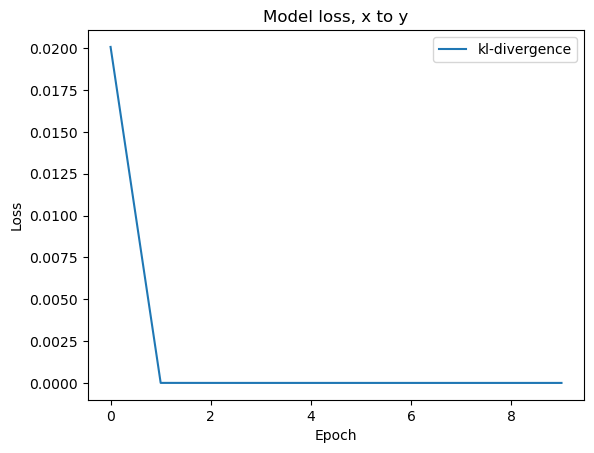

In [99]:
#学習曲線
#plt.plot(hist.history['loss'][:10], label = "loss")
plt.plot(hist.history['kl_divergence'][:10], label = "kl-divergence")
plt.title('Model loss, x to y')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(f"./result/vrnn_predict/delay_Model_kl.png")
plt.show()


# 潜在変数と隠れ状態の可視化

In [77]:
z = outputs[5]
phi_z = outputs[6]
h = outputs[7]

# UMAP

In [ ]:
import umap
reducer = umap.UMAP( n_neighbors = 2)
um = reducer.fit_transform(z)
plt.scatter(um[:, 0], um[:, 1], c=time, cmap="rainbow", alpha=0.9)

In [ ]:
num_frames = 2440  # アニメーションのフレーム数
prints_per_frame = 2440  # 各フレームのデータポイント数
tg = "z"
tt = np.linspace(0, 1, 2440)
# プロットの設定
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
scat = ax1.scatter(um[:, 0], um[:, 1], c=pred_y, cmap="rainbow", alpha=0.9)
ax1.set_title("No.{:>2d}, tsne_{}, , h_dim ={:<3d}, z_dim = {:>2d}, Epoch = {:>3d}".format(id, tg, h_dim, z_dim, epochs))
ax1.set_ylabel('{}[1]'.format(tg))
ax1.set_xlabel('{}[0]'.format(tg))
ax1.grid()
colorbar = plt.colorbar(scat)
time_text1 = ax1.text(0.5, 0.95, '', transform=ax1.transAxes, ha='center', fontsize=12)

line, = ax2.plot(np.squeeze(pred_y), linestyle="--", color="orange", label="pred")
ax2.set_title("No.{:>2d}, pred_y".format(id))
ax2.set_ylabel('{}[1]'.format(tg))
ax2.set_xlabel('{}[0]'.format(tg))
ax2.grid()

time_text2 = ax2.text(0.5, 0.95, '', transform=ax2.transAxes, ha='center', fontsize=12)
all_offsets = []
all_colors = []

# アニメーションの更新関数
def update(frame):
    # scat.set_offsets(proj[frame])
    # scat.set_array(pred_y[frame])
    
    # # line.set_data(np.squeeze(pred_y[frame]))
    line.set_data(range(frame + 1), np.squeeze(pred_y[:frame + 1]))
    all_offsets.append(um[frame])
    all_colors.append(pred_y[frame])

    # scatter plotのデータを更新
    scat.set_offsets(all_offsets)
    scat.set_array(np.array(all_colors).flatten())

    time_text1.set_text(f'Time: {frame:.2f}')
    time_text2.set_text(f'Time: {frame:.2f}')
    
    return scat, line, time_text1, time_text2

# アニメーションの作成
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=100, blit=True)

# アニメーションの保存（必要に応じて）
ani.save(f"./result/flame_2450/Val100_No{id}_umap_{tg}_pred.mp4", writer='ffmpeg')
plt.show()


In [81]:
min(pred_y)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.06394386], dtype=float32)>

# tsne

findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: 

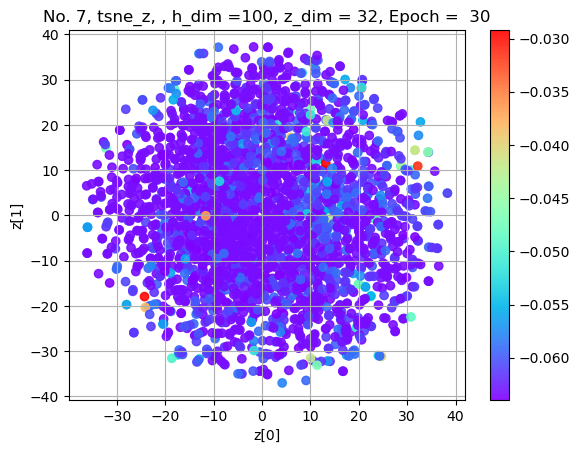

In [83]:
prexity = 35
iter = 1000
learning = 200
pre = "35"
ite = "1000"
learn = "200"
tsne = TSNE(n_components=2, perplexity=prexity, learning_rate=learning, n_iter = iter)
#tsne = TSNE(n_components=2)
time = np.arange(0, 2440, 1)
time1 = np.arange(0, 2440, 1)
time2 = np.arange(0, 2440, 1)
z_ = z[50:500]
proj = tsne.fit_transform(phi_z)
tg = "z"


# plt.title("tsne_h, , h_dim ={:<3d}, z_dim = {:>2d}, Epoch = {:>3d}".format(h_dim, z_dim, epochs))
plt.title("No.{:>2d}, tsne_{}, , h_dim ={:<3d}, z_dim = {:>2d}, Epoch = {:>3d}".format(id, tg, h_dim, z_dim, epochs))
scatter = plt.scatter(proj[:, 0], proj[:, 1], c=pred_y, cmap="rainbow", alpha=0.9, vmin=min(pred_y), vmax=max(pred_y))
#plt.scatter(time1, time2, c=time, cmap="rainbow", alpha=1.0)
plt.ylabel('{}[1]'.format(tg))
plt.xlabel('{}[0]'.format(tg))
colorbar = plt.colorbar(scatter)
#plt.xlim(-79, 100)  # x軸の範囲設定
# plt.xticks(np.arange(-20, 20, 5))
# plt.yticks(np.arange(-20, 20, 5))
#plt.ylim(-35, 60)  # y軸の範囲設定
plt.grid()
plt.savefig(f"./result/vrnn_predict/No{id}_tsne_{tg}_pln{pre, learn, ite}.png")

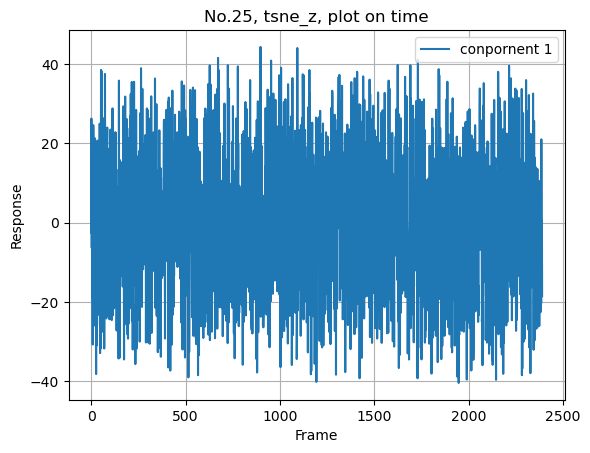

In [84]:
plt.title("No.{:>2d}, tsne_{}, plot on time".format(id, tg, h_dim, z_dim, epochs))
plt.plot(proj[:, 0], label = "conpornent 1")
#plt.plot(proj[:, 1], label = "conpornent 2")
#plt.plot(pred_y, label  = "pred")
plt.xlabel('Frame'.format(tg))
plt.ylabel('Response'.format(tg))
plt.grid()
plt.legend()
plt.savefig(f"./result/flame_2450/No{id}_tsne_{tg}_pred2400_on_time1_.png")


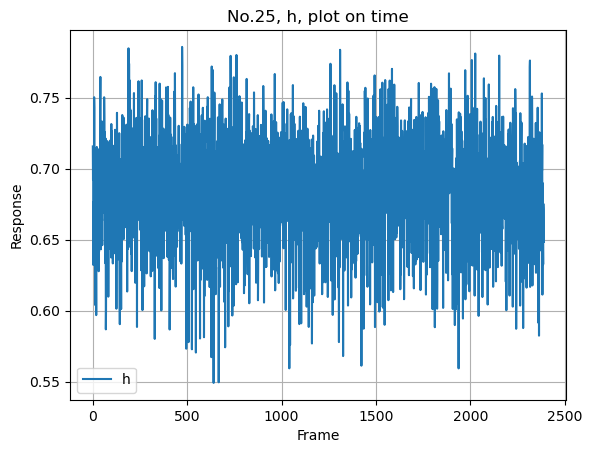

In [85]:
plt.title("No.{:>2d}, h, plot on time".format(id, tg, h_dim, z_dim, epochs))
#plt.plot(proj[:, 0], label = "conpornent 1")
plt.plot(h[:, 0], label = "h")
#plt.plot(pred_y, label  = "pred")
plt.xlabel('Frame'.format(tg))
plt.ylabel('Response'.format(tg))
plt.grid()
plt.legend()
plt.savefig(f"./result/flame_2450/No{id}_tsne_h_pred2400_on_time1_.png")


In [ ]:
num_frames = 2440  # アニメーションのフレーム数
points_per_frame = 2440  # 各フレームのデータポイント数
tg = "z"

# プロットの設定
fig, ax = plt.subplots()
scat = ax.scatter(proj[:, 0], proj[:, 1], c=pred_y, cmap="rainbow", alpha=0.9)
ax.set_title("No.{:>2d}, tsne_{}, , h_dim ={:<3d}, z_dim = {:>2d}, Epoch = {:>3d}".format(id, tg, h_dim, z_dim, epochs))
ax.set_ylabel('{}[1]'.format(tg))
ax.set_xlabel('{}[0]'.format(tg))
ax.grid()
colorbar = plt.colorbar(scat)

# アニメーションの更新関数
def update(frame):
    scat.set_offsets(proj[frame])
    scat.set_array(pred_y[frame])
    return scat,

# アニメーションの作成
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=200, blit=True)

# アニメーションの保存（必要に応じて）
ani.save(f"./result/flame_2450/No{id}_tsne_{tg}_pred.mp4", writer='ffmpeg')
plt.show()


In [ ]:
num_frames = 2440  # アニメーションのフレーム数
prints_per_frame = 2440  # 各フレームのデータポイント数
tg = "z"
tt = np.linspace(0, 1, 2440)
# プロットの設定
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
scat = ax1.scatter(proj[:, 0], proj[:, 1], c=pred_y, cmap="rainbow", alpha=0.9)
ax1.set_title("No.{:>2d}, tsne_{}, , h_dim ={:<3d}, z_dim = {:>2d}, Epoch = {:>3d}".format(id, tg, h_dim, z_dim, epochs))
ax1.set_ylabel('{}[1]'.format(tg))
ax1.set_xlabel('{}[0]'.format(tg))
ax1.grid()
colorbar = plt.colorbar(scat)
time_text1 = ax1.text(0.5, 0.95, '', transform=ax1.transAxes, ha='center', fontsize=12)

line, = ax2.plot(np.squeeze(pred_y), linestyle="--", color="orange", label="pred")
ax2.set_title("No.{:>2d}, pred_y".format(id))
ax2.set_ylabel('{}[1]'.format(tg))
ax2.set_xlabel('{}[0]'.format(tg))
ax2.grid()

time_text2 = ax2.text(0.5, 0.95, '', transform=ax2.transAxes, ha='center', fontsize=12)
all_offsets = []
all_colors = []

# アニメーションの更新関数
def update(frame):
    # scat.set_offsets(proj[frame])
    # scat.set_array(pred_y[frame])
    
    # # line.set_data(np.squeeze(pred_y[frame]))
    line.set_data(range(frame + 1), np.squeeze(pred_y[:frame + 1]))
    all_offsets.append(proj[frame])
    all_colors.append(pred_y[frame])

    # scatter plotのデータを更新
    scat.set_offsets(all_offsets)
    scat.set_array(np.array(all_colors).flatten())

    time_text1.set_text(f'Time: {frame:.2f}')
    time_text2.set_text(f'Time: {frame:.2f}')
    
    return scat, line, time_text1, time_text2

# アニメーションの作成
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=8, blit=True)

# アニメーションの保存（必要に応じて）
ani.save(f"./result/flame_2450/Val100_No{id}_tsne_{tg}_pred.mp4", writer='ffmpeg')
plt.show()


# PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
# PCAライブラリをインポート
from sklearn.decomposition import PCA

In [ ]:
# 標準化
sc = StandardScaler()
z_std = sc.fit_transform(z)
phi_z_std = sc.fit_transform(phi_z)
h_std = sc.fit_transform(h)

pca_z = PCA(n_components=10, random_state=100)
pca_phi_z = PCA(n_components=2, random_state=100)
pca_h = PCA(n_components=2, random_state=100)

z_pca = pca_z.fit_transform(z_std)
phi_z_pca = pca_phi_z.fit_transform(phi_z_std)
h_pca = pca_h.fit_transform(h_std)



In [ ]:
eigenvalues_z = pca_z.explained_variance_
eigenvalues_phi_z = pca_phi_z.explained_variance_
eigenvalues_h = pca_h.explained_variance_

# 寄与率（explained variance ratio）
explained_variance_ratio_z = pca_z.explained_variance_ratio_
explained_variance_ratio_phi_z = pca_phi_z.explained_variance_ratio_
explained_variance_ratio_h = pca_h.explained_variance_ratio_

# 主成分負荷量（component loadings）
components_z = pca_z.components_
components_phi_z = pca_phi_z.components_
components_h = pca_h.components_

# 主成分得点（principal component scores）
scores_z = z_pca
scores_phi_z = phi_z_pca
scores_h = h_pca

print("Z data PCA results:")
print("固有値:", eigenvalues_z)
print("寄与率:", explained_variance_ratio_z)
print("主成分負荷量:", components_z)
print("主成分得点:", scores_z)

# print("\nPhi_Z data PCA results:")
# print("Eigenvalues:", eigenvalues_phi_z)
# print("Explained Variance Ratio:", explained_variance_ratio_phi_z)
# print("Components:", components_phi_z)
# print("Scores:", scores_phi_z)

# print("\nH data PCA results:")
# print("Eigenvalues:", eigenvalues_h)
# print("Explained Variance Ratio:", explained_variance_ratio_h)
# print("Components:", components_h)
# print("Scores:", scores_h)

In [ ]:
 plt.plot(tt, np.squeeze(pred_y), linestyle="--", color="orange", label="pred")

In [ ]:
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=pred_y, cmap="rainbow", alpha=0.9)
tg1 = "z"
plt.colorbar()
plt.ylabel('{}[0]'.format(tg1))
plt.xlabel('{}[1]'.format(tg1))
plt.grid()
plt.title("No.{}, pca_{}, h_dim ={:<3d}, z_dim = {:>2d}, Epoch = {:>3d}".format(id, tg1, h_dim, z_dim, epochs))
plt.savefig(f"./result/flame_2450/No{id}_pca_{tg1}_pred.png")

In [ ]:
pred_y10 = []
z_pcax = []
z_pcay =[]
for i in range (244):
    pred_y10.append(pred_y[i*10])
    z_pcax.append(z_pca[i*10, 0])
    z_pcay.append(z_pca[i*10, 1])

plt.scatter(z_pcax, z_pcay,c = pred_y10,cmap="rainbow", alpha=0.9)

tg1 = "z"
plt.colorbar()
plt.ylabel('{}[0]'.format(tg1))
plt.xlabel('{}[1]'.format(tg1))
plt.grid()
plt.title("No.{}, pca_{}, h_dim ={:<3d}, z_dim = {:>2d}, Epoch = {:>3d}".format(id, tg1, h_dim, z_dim, epochs))
plt.savefig(f"./result/flame_2450/No{id}_pca_{tg1}_pred.png")

In [ ]:
num_frames = 10  # アニメーションのフレーム数
prints_per_frame = 10  # 各フレームのデータポイント数
tg = "z"
tt = np.linspace(0, 1, 2440)
# プロットの設定
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
#scat = ax1.scatter(z_pca[:, 0], z_pca[:, 1], c=pred_y, cmap="rainbow", alpha=0.9)
scat = ax1.scatter(z_pcax, z_pcay,c = pred_y10,cmap="rainbow", alpha=0.9)
ax1.set_title("No.{:>2d}, pca_{}, , h_dim ={:<3d}, z_dim = {:>2d}, Epoch = {:>3d}".format(id, tg, h_dim, z_dim, epochs))
ax1.set_ylabel('{}[1]'.format(tg))
ax1.set_xlabel('{}[0]'.format(tg))
ax1.grid()
colorbar = plt.colorbar(scat)
time_text1 = ax1.text(0.5, 0.95, '', transform=ax1.transAxes, ha='center', fontsize=12)

#line, = ax2.plot(np.squeeze(pred_y), linestyle="--", color="orange", label="pred")
line, = ax2.plot(np.squeeze(pred_y), linestyle="--", color="orange", label="pred")
ax2.set_title("No.{:>2d}, pred_y".format(id))
ax2.set_ylabel('{}[1]'.format(tg))
ax2.set_xlabel('{}[0]'.format(tg))
ax2.grid()

time_text2 = ax2.text(0.5, 0.95, '', transform=ax2.transAxes, ha='center', fontsize=12)
all_offsets = []
all_colors = []

# アニメーションの更新関数
def update(frame):
    # scat.set_offsets(proj[frame])
    # scat.set_array(pred_y[frame])
    
    # # line.set_data(np.squeeze(pred_y[frame]))
    line.set_data(range(frame*10 + 1), np.squeeze(pred_y[:frame*10 + 1]))
    all_offsets.append(z_pcax[frame])
    all_offsets.append(z_pcay[frame])
    
    all_colors.append(pred_y[frame*10])

    # scatter plotのデータを更新
    scat.set_offsets(all_offsets)
    scat.set_array(np.array(all_colors).flatten())

    time_text1.set_text(f'Time: {frame:.2f}')
    time_text2.set_text(f'Time: {frame:.2f}')
    
    return scat, line, time_text1, time_text2

# アニメーションの作成
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=100, blit=True)

# アニメーションの保存（必要に応じて）
ani.save(f"./result/flame_2450/Val100_No{id}_pca_{tg}_pred.mp4", writer='ffmpeg')
plt.show()

# decoder

In [47]:
# VRNNCellのインスタンスを取得
vrnn_cell_instance = model.layers[0]  

# VRNNCellのdecoderを取り出す
decoder_layer = vrnn_cell_instance.decoder

# decoderモデルを作成
decoder_model = keras.Sequential()
decoder_model.add(decoder_layer)

#decoder_layer.get_weights()

In [48]:
max_h = tf.reduce_max(h)
min_h = tf.reduce_min(h)

In [66]:
phi_z = outputs[6]
noise = tf.random.uniform(shape=[2440, 100], minval=min_h, maxval=max_h)
zero = tf.random.uniform(shape=[2440, 100], minval=0, maxval=0)

phi_z_zero = keras.layers.Concatenate(axis=(1))([h, zero])
phi_z_noise = keras.layers.Concatenate(axis=(1))([phi_z, noise])

phi_z_zero_decoded = decoder_model.predict(phi_z_zero)
phi_z_noise_decoded = decoder_model.predict(phi_z_noise)

77/77 [==============================] - 0s 1ms/step


In [53]:
phi_z.shape

TensorShape([2440, 100])

In [ ]:
phi_z_h.shape

In [ ]:
# z1 = np.linspace(-2, 2, 100)
# z2 = np.linspace(-1, 1, 100)
 
# num_of_rows = 10
# fig, ax = plt.subplots(nrows=num_of_rows, ncols=num_of_rows, figsize=(10, 10))
# for i, (z1_, z2_) in enumerate(zip(z1, z2)):
#     rand_z = np.array([z1_, z2_])
#     rand_z_h = keras.layers.Concatenate(axis=(1))([rand_z, h])  
#     sampled = decoder_model.predict(phi_z_h).reshape(1, 2)
#     ax[divmod(i, num_of_rows)].imshow(sampled.numpy().reshape(28, 28) * 255, cmap='Greys');
#     ax[divmod(i, num_of_rows)].set_axis_off()
# plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

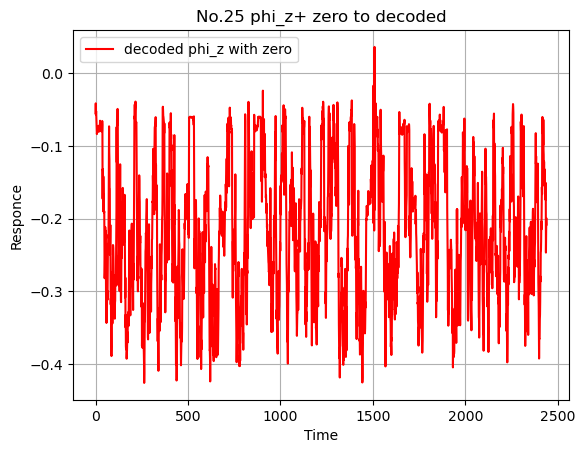

In [67]:
plt.figure()
plt.title("No.{} phi_z+ zero to decoded".format(id))
plt.plot(phi_z_zero_decoded, linestyle="-", color="red", label="decoded phi_z with zero")
#plt.plot(phi_z_noise_decoded, linestyle="-", color="blue", label="decoded phi_z with noise")
#plt.plot(np.squeeze(data_Qex[id, :]), linestyle="-", color="green",label = "x")
plt.legend()
plt.grid()
plt.ylabel('Responce')
plt.xlabel('Time')
plt.savefig(f"./result/flame_2450/decoded_No{id}_h_zero_pred24001.png")
plt.show

ValueError: x and y can be no greater than 2D, but have shapes (47800,) and (47800, 10, 1)

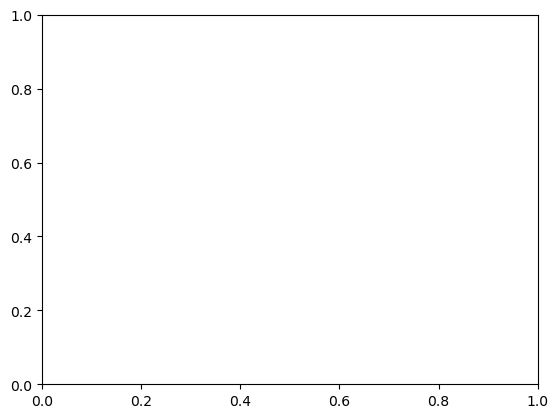

In [68]:
plt.plot(train_x)